In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mayavi.mlab
from mpl_toolkits.mplot3d import Axes3D

In [2]:
gt_box3d = np.load('./Code_sample/didi-udacity-2017/data/one_frame/gt_boxes3d.npy')
gt_label = np.load('./Code_sample/didi-udacity-2017/data/one_frame/gt_labels.npy')
gt_top_box = np.load('./Code_sample/didi-udacity-2017/data/one_frame/gt_top_boxes.npy')
lidar = np.load('./Code_sample/didi-udacity-2017/data/one_frame/lidar.npy')
rgb = np.load('./Code_sample/didi-udacity-2017/data/one_frame/rgb.npy')
top = np.load('./Code_sample/didi-udacity-2017/data/one_frame/top.npy')
print('gt_box3d: ', gt_box3d.shape)
print('gt_label: ', gt_label.shape)
print('gt_top_box: ', gt_top_box.shape)
print('lidar: ', lidar.shape)
print('rgb: ', rgb.shape)
print('top: ', top.shape)

('gt_box3d: ', (3, 8, 3))
('gt_label: ', (3,))
('gt_top_box: ', (3, 4))
('lidar: ', (123397, 4))
('rgb: ', (375, 1242, 3))
('top: ', (400, 400, 8))


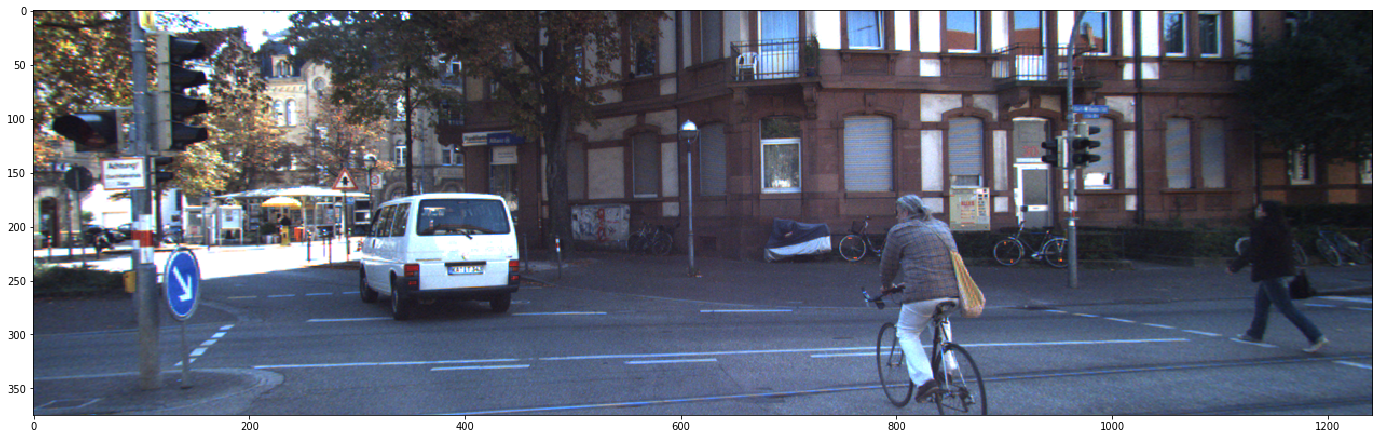

In [3]:
fig, ax = plt.subplots(1,1, figsize = (24,10))
ax.imshow(rgb)

In [4]:
# lidar characteristic
# http://velodynelidar.com/docs/datasheet/63-9194_Rev-F_HDL-64E_S3_Data%20Sheet_Web.pdf
def cylindrical_projection(lidar, 
                           ver_fov = (-24.9, 2.), 
                           hor_fov = (-180, 180), 
                           v_res = 0.42,
                           h_res = 0.35,
                           d_max = None):
    '''
    lidar: a numpy array of shape N*D, D>=3
    ver_fov : angle range of vertical projection in degree
    hor_fov: angle range of horizantal projection in degree
    v_res : vertical resolusion
    h_res : horizontal resolution
    d_max : maximun range distance
    
    return : cylindrical projection (or panorama view) of lidar
    '''
    
    x = lidar[:,0]
    y = lidar[:,1]
    z = lidar[:,2]
    d = np.sqrt(np.square(x)+np.square(y))
    
    if d_max != None:
        d[d>d_max] = d_max
    
    
    theta = np.arctan2(-y, x)
    phi = -np.arctan2(z, d)
    
    x_view = np.int16(np.ceil((theta*180/np.pi - hor_fov[0])/h_res))
    y_view = np.int16(np.ceil((phi*180/np.pi + ver_fov[1])/v_res))
    
    x_max = int(np.ceil((hor_fov[1] - hor_fov[0])/h_res))
    y_max = int(np.ceil((ver_fov[1] - ver_fov[0])/v_res))
    
    
    indices = np.logical_and( np.logical_and(x_view >= 0, x_view <= x_max), 
                           np.logical_and(y_view >= 0, y_view <= y_max)  )
    
    x_view = x_view[indices]
    y_view = y_view[indices]
    z = z[indices]
    d = d[indices]
    d_z = [[d[i],z[i]] for i in range(len(d))]
    
    width_view = int(np.ceil((hor_fov[1] - hor_fov[0])/h_res)) 
    height_view = int(np.ceil((ver_fov[1] - ver_fov[0])/v_res))
    
    view = np.zeros([height_view+1, width_view+1, 2],dtype=np.float64)
    view[y_view,x_view] = d_z
    return view

(66, 230, 2)


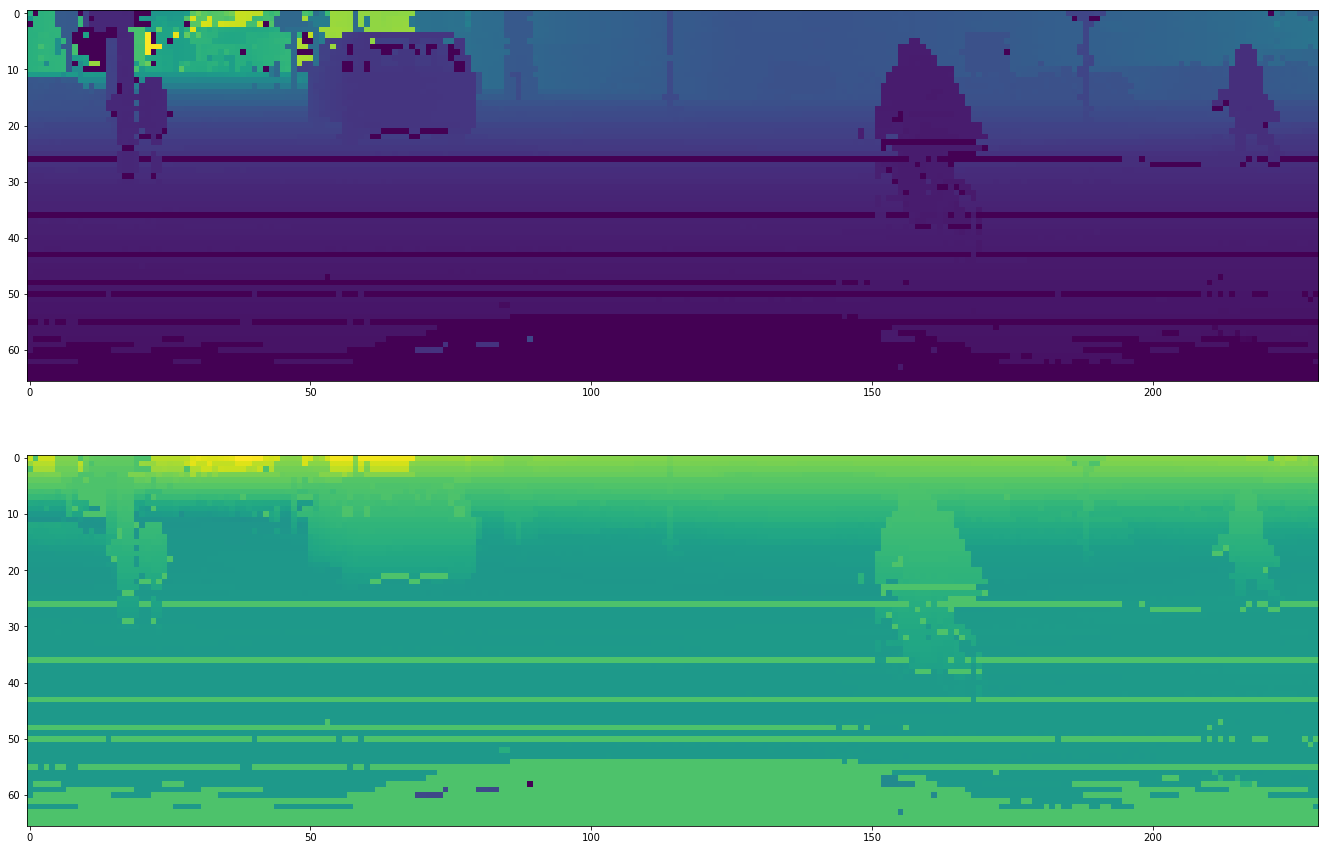

In [5]:
view = cylindrical_projection(lidar, 
                           ver_fov = (-24.9, 2.), 
                           hor_fov = (-40,40), 
                           v_res = 0.42,
                           h_res = 0.35,
                           d_max = None)
print(view.shape)
fig, ax = plt.subplots(2,1, figsize = (24,15))
ax[0].imshow(view[:,:,0])
ax[1].imshow(view[:,:,1])


In [6]:
def viz_mayavi_with_labels(points, boxes, view_boxes = True, vals="distance"):
    x = points[:, 0]  # x position of point
    y = points[:, 1]  # y position of point
    z = points[:, 2]  # z position of pointfrom mpl_toolkits.mplot3d import Axes3D
    # r = lidar[:, 3]  # reflectance value of point
    d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor

    # Plot using mayavi -Much faster and smoother than matplotlib
    #import mayavi.mlab
    if vals == "height":
        col = z
    else:
        col = d

    fig = mayavi.mlab.figure(bgcolor=(0, 0, 0), size=(640, 360))
    mayavi.mlab.points3d(x, y, z,
                         col,          # Values used for Color
                         mode="point",
                         colormap='spectral', # 'bone', 'copper', 'gnuplot'
                         # color=(0, 1, 0),   # Used a fixed (r,g,b) instead
                         figure=fig,
                         )
    
    if view_boxes:
        for i in range(len(boxes)):
            car = boxes[i]
            x = car[:,0]
            y = car[:,1]
            z = car[:,2]

            mayavi.mlab.plot3d(x[:4], y[:4], z[:4], tube_radius=0.025)#, colormap='Spectral')
            mayavi.mlab.plot3d(x[[0,3]], y[[0,3]], z[[0,3]], tube_radius=0.025)
            mayavi.mlab.plot3d(x[[0,4]], y[[0,4]], z[[0,4]], tube_radius=0.025)
            mayavi.mlab.plot3d(x[[1,5]], y[[1,5]], z[[1,5]], tube_radius=0.025)
            mayavi.mlab.plot3d(x[[2,6]], y[[2,6]], z[[2,6]], tube_radius=0.025)
            mayavi.mlab.plot3d(x[[3,7]], y[[3,7]], z[[3,7]], tube_radius=0.025)


            mayavi.mlab.plot3d(x[-4:], y[-4:], z[-4:], tube_radius=0.025)#, colormap='Spectral')
            mayavi.mlab.plot3d(x[[4,7]], y[[4,7]], z[[4,7]], tube_radius=0.025)
        
    mayavi.mlab.show()

In [7]:
viz_mayavi_with_labels(lidar, gt_box3d)